In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
# Load the data
train_df = pd.read_csv('/Masters/ANN/Assignment/IMDB Movie Review/train.tsv', sep='\t')
test_df = pd.read_csv('/Masters/ANN/Assignment/IMDB Movie Review/test.tsv', sep='\t')

In [3]:
# Load stopwords
with open('/Masters/ANN/Assignment/IMDB Movie Review/stopwords.txt', 'r') as f:
    stopwords = set(f.read().splitlines())

In [4]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nhyuj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
to_replace = {
    "don\'t": "do not",
    "dont": "do not",
    "doesn\'t": "does not",
    "doesnt": "does not",
    "didn\'t": "did not",
    "didnt": "did not",
    "shouldn\'t": "should not",
    "shouldnt": "should not",
    "mustn\'t": "must not",
    "mustnt": "must not",
    "haven\'t": "have not",
    "hvn\'t": "have not",
    "havent": "have not",
    "hadn\'t": "had not",
    "hadnt": "had not",
    "can\'t": "can not",
    "cant": "can not",
    "cannot": "can not",
    "cann\'t": "can not",
    "couldn\'t": "could not",
    "couldnt": "could not",
    "aren\'t": "are not",
    "arent": "are not",
    "isn\'t": "is not",
    "isnt": "is not",
    "wasn\'t": "was not",
    "wasnt": "was not",
    "weren\'t": "were not",
    "werent": "were not",
    "won\'t": "will not",
    "wont": "will not",
    "wouldn\'t": "would not",
    "wouldnt": "would not",
}

In [6]:
def replace_contractions(sentence, to_replace):
    pattern = re.compile(r'\b(' + '|'.join(to_replace.keys()) + r')\b')
    
    return pattern.sub(lambda x: to_replace[x.group()], sentence)

def decontracted(phrase):
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [8]:
# Function to get the part of speech tag for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
# Text preprocessing function
def preprocess_text(text):
    # Remove special characters and lowercase
    text = text.lower()
    text = replace_contractions(text, to_replace)
    text = decontracted(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words if word not in stopwords]
    return ' '.join(words)

In [10]:
example = "I don't like this movie, it doesn't make sense. he won't watch it again in 2024 @ !"
print(preprocess_text(example))

like make sense watch


In [11]:
from tqdm import tqdm
tqdm.pandas()

# Apply preprocessing
train_df['cleaned_review'] = train_df['review'].progress_apply(preprocess_text)
test_df['cleaned_review'] = test_df['review'].progress_apply(preprocess_text)

100%|██████████████████████████████████████████████████████████████████████████████| 2681/2681 [01:04<00:00, 41.36it/s]


In [12]:
train_df.head()

,sentiment,review,cleaned_review
0,1,But it's really slow to catch on . For me a mo...,really slow catch like rocket ain fast enough ...
1,1,"To me, it's controversial how this movie has s...",controversial high rating praise understandabl...
2,1,"The movie is a tricky and the story is good, b...",tricky story good actor do great act
3,0,I can not believe that this movie received all...,believe receive award long slow move predictab...
4,2,Usually the debate is wether godfather or Good...,usually debate wether godfather goodfellas wel...


In [13]:
# Tokenize the cleaned reviews
tokenizer = Tokenizer(num_words=10000)  # Use the top 10000 words
tokenizer.fit_on_texts(train_df['cleaned_review'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_review'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_review'])

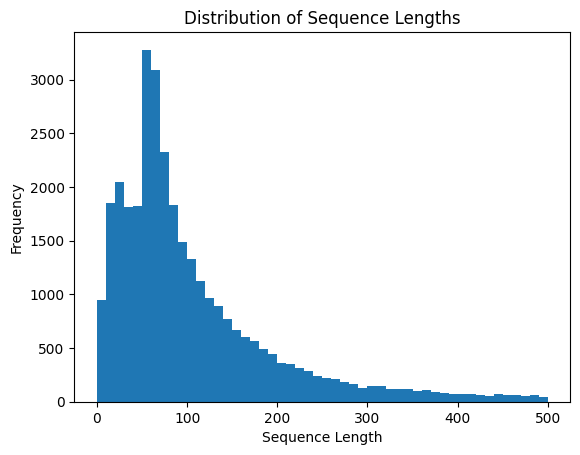

In [14]:
import matplotlib.pyplot as plt

# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in train_sequences]

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50, range=(0, 500))
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Calculate the 95th percentile
max_length_95 = int(np.percentile(sequence_lengths, 95))

print(f'95th percentile of sequence lengths: {max_length_95}')

95th percentile of sequence lengths: 318


In [16]:
# Define maximum sequence length
max_length = 200

# Pad the sequences to ensure uniform length
X_train = pad_sequences(train_sequences, maxlen=max_length)
X_test = pad_sequences(test_sequences, maxlen=max_length)

In [17]:
# Encode sentiment labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment'])
y_test = label_encoder.transform(test_df['sentiment'])

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [30]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(len(word_index) + 1, 10000)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim,  
              weights=[embedding_matrix], 
              trainable=False),
    LSTM(32,  return_sequences=True),
    Dropout(0.6),
    LSTM(16),
    Dropout(0.6),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [31]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.4266 - loss: 1.0535 - val_accuracy: 0.5593 - val_loss: 0.9151
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.5547 - loss: 0.9353 - val_accuracy: 0.5886 - val_loss: 0.8785
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.5790 - loss: 0.8937 - val_accuracy: 0.5909 - val_loss: 0.8707
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.5961 - loss: 0.8667 - val_accuracy: 0.6143 - val_loss: 0.8380
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 42s 102ms/step - accuracy: 0.6100 - loss: 0.8537 - val_accuracy: 0.6157 - val_loss: 0.8296
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 47s 115ms/step - accuracy: 0.6190 - loss: 0.8373 - val_accuracy: 0.6064 - val_loss: 0.8341
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 48s 117ms/step - accuracy: 0.6286 - loss: 0.8195 - val_accuracy: 0.6122 - val_loss: 0.8155
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 46s 111ms/step - accuracy: 0.6329 - loss: 0.802

In [32]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5512 - loss: 1.2747
Test Accuracy: 0.5435


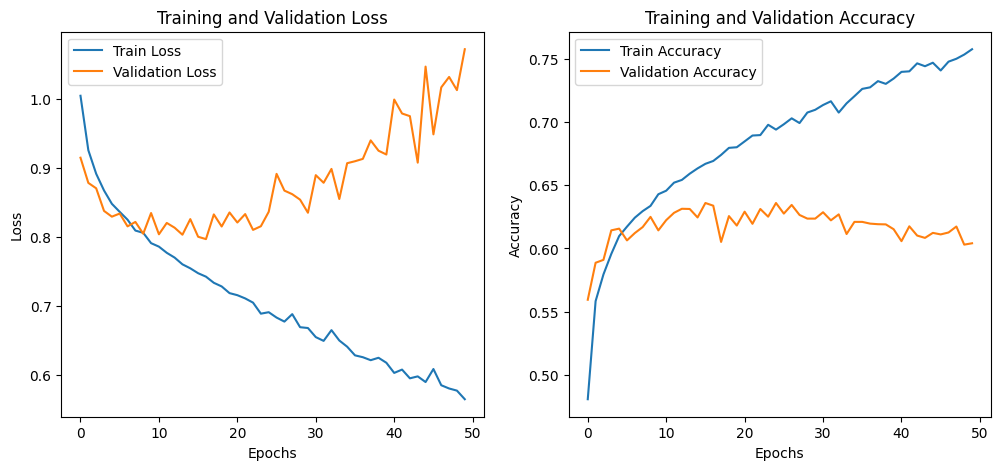

In [33]:
# Extract loss and accuracy from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
# Predict sentiment for new reviews
new_reviews = ["This movie was fantastic! I loved it.", "The plot was boring and predictable.", "The movie was alright. I didn't like the romance but the action was okay."]
new_sequences = tokenizer.texts_to_sequences(new_reviews)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length)

# Predict the sentiments
predictions = model.predict(new_padded_sequences)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
[2 0 1]
